In [1]:
!pip install pareto

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pareto
import math
import scipy.stats as st

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Frente de pareto

Load GridSearch results:

In [3]:
dfs = {}
for dataset in ['ml100k', 'ml1m', 'ml10m', 'ft', 'anime']:
    df = {}
    for m in ['ResBeMF', 'BeMF', 'DirMF', 'PMF', 'BiasedMF', 'MLP']:
        aux = pd.read_csv('results/gridsearch/' + dataset + '/' + m.lower() +'.csv')
        #aux = aux[aux['cummulativemae_avg'] >= 0.05]
        aux = aux[aux['cummulativecoverage_fold_0'] >= 0.02]
        aux = aux[aux['cummulativecoverage_fold_1'] >= 0.02]
        aux = aux[aux['cummulativecoverage_fold_2'] >= 0.02]
        aux = aux[aux['cummulativecoverage_fold_3'] >= 0.02]
        aux = aux[aux['cummulativecoverage_fold_4'] >= 0.02]
        df[m] = aux
    dfs[dataset] = df

Plot the scatter:

In [4]:
def plot_hypeparameters(dfs, dataset):
    df = dfs[dataset]
    
    params = ['numFactors', 'regularization', 'learningRate', 'numIters']
    methods = ['ResBeMF', 'BeMF', 'DirMF']
    cmaps = ['Blues', 'Oranges', 'Greens']

    fig, axs = plt.subplots(len(params), len(methods), figsize=(6*len(methods),3.75*len(params)))
    fig.tight_layout(h_pad=4, w_pad=6.5)

    for i, param in enumerate(params):
        for j, method in enumerate(methods):

            axs[i,j].set_xlabel('coverage', fontsize=17)
            axs[i,j].set_ylabel('1-mae', fontsize=17)

            if i == 0:
                axs[i,j].set_title(method, fontsize=20)

            axs[i,j].tick_params(axis='both', which='major', labelsize=14)

            mae = df[method]['cummulativemae_avg']
            coverage = df[method]['cummulativecoverage_avg']
            color = df[method][param] 

            norm = colors.LogNorm(vmin=color.min(), vmax=color.max()) if param == 'regularization' and (method == 'BeMF' or (method == 'ResBeMF' and dataset == 'anime')) else None

            im = axs[i,j].scatter(coverage, mae, c=color, cmap=cmaps[j], norm=norm)

            cbar = plt.colorbar(im, ax=axs[i,j])
            cbar.set_label(param, fontsize=15)
            cbar.ax.tick_params(labelsize=14)

    plt.savefig('./figs/' + dataset + '-hyperparameters.png', dpi=300, bbox_inches='tight')

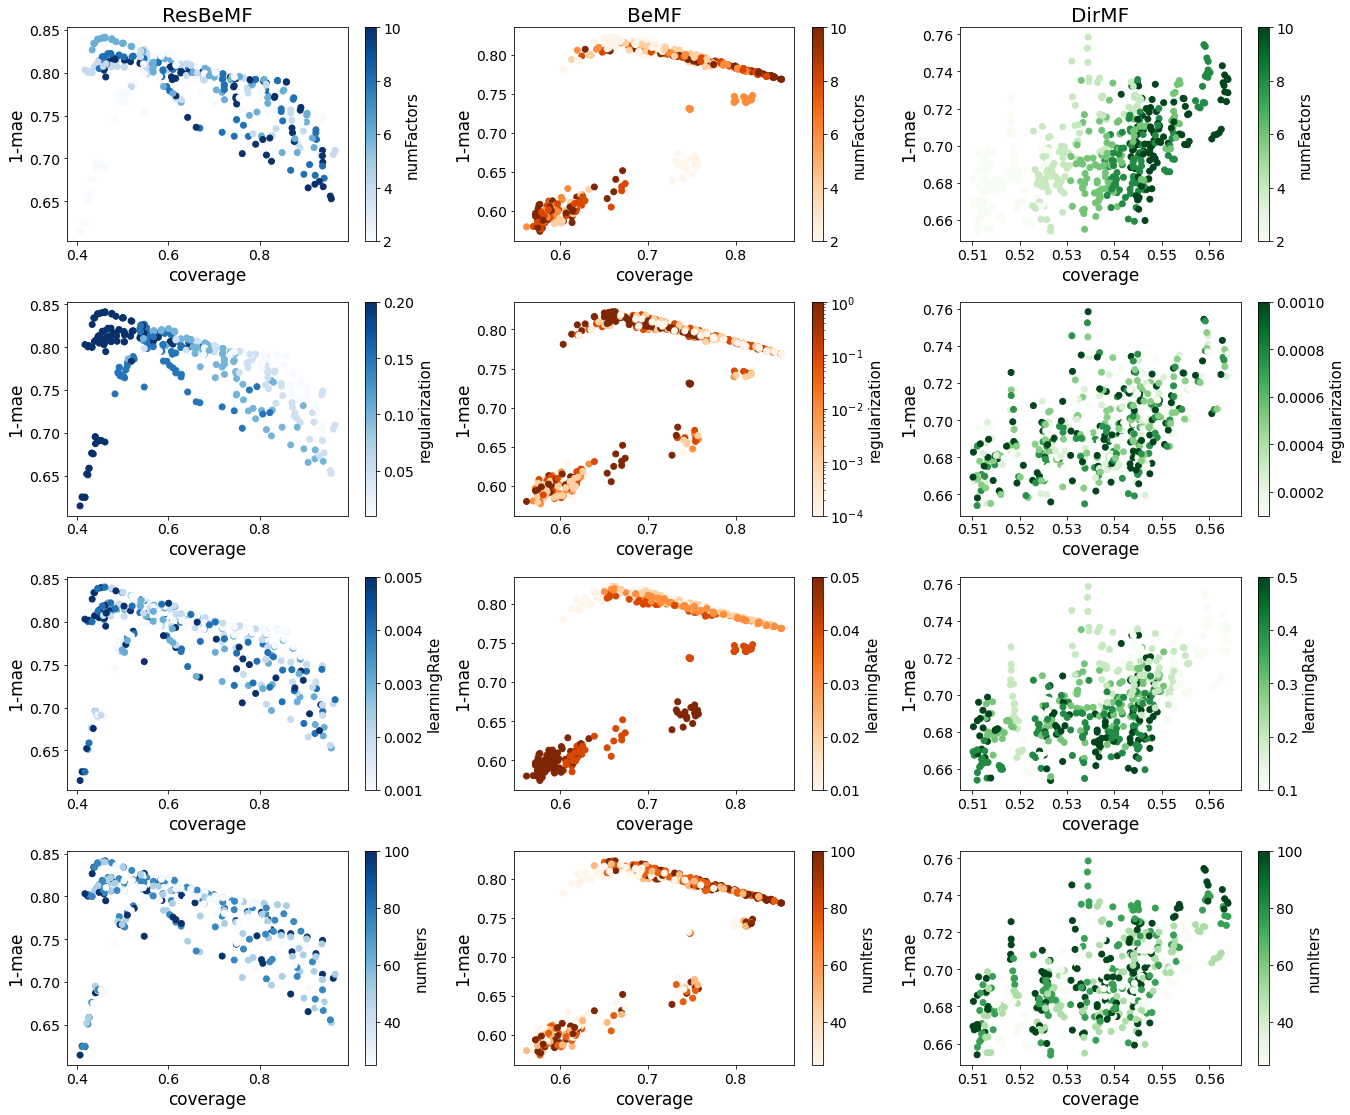

In [5]:
plot_hypeparameters(dfs, 'ml100k')

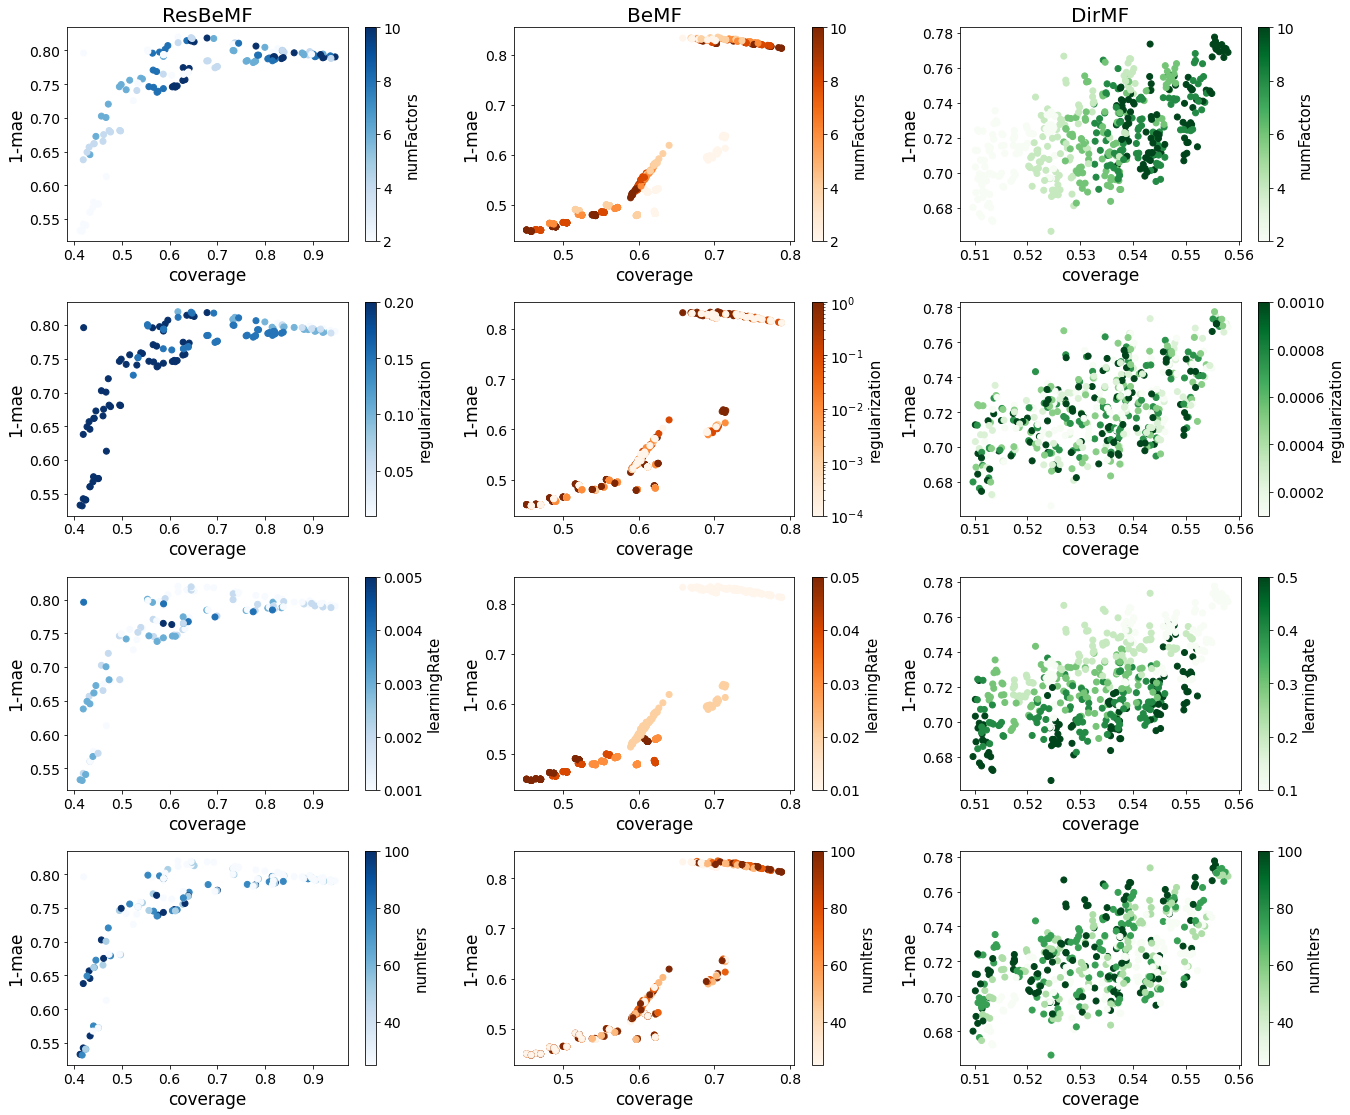

In [6]:
plot_hypeparameters(dfs, 'ml1m')

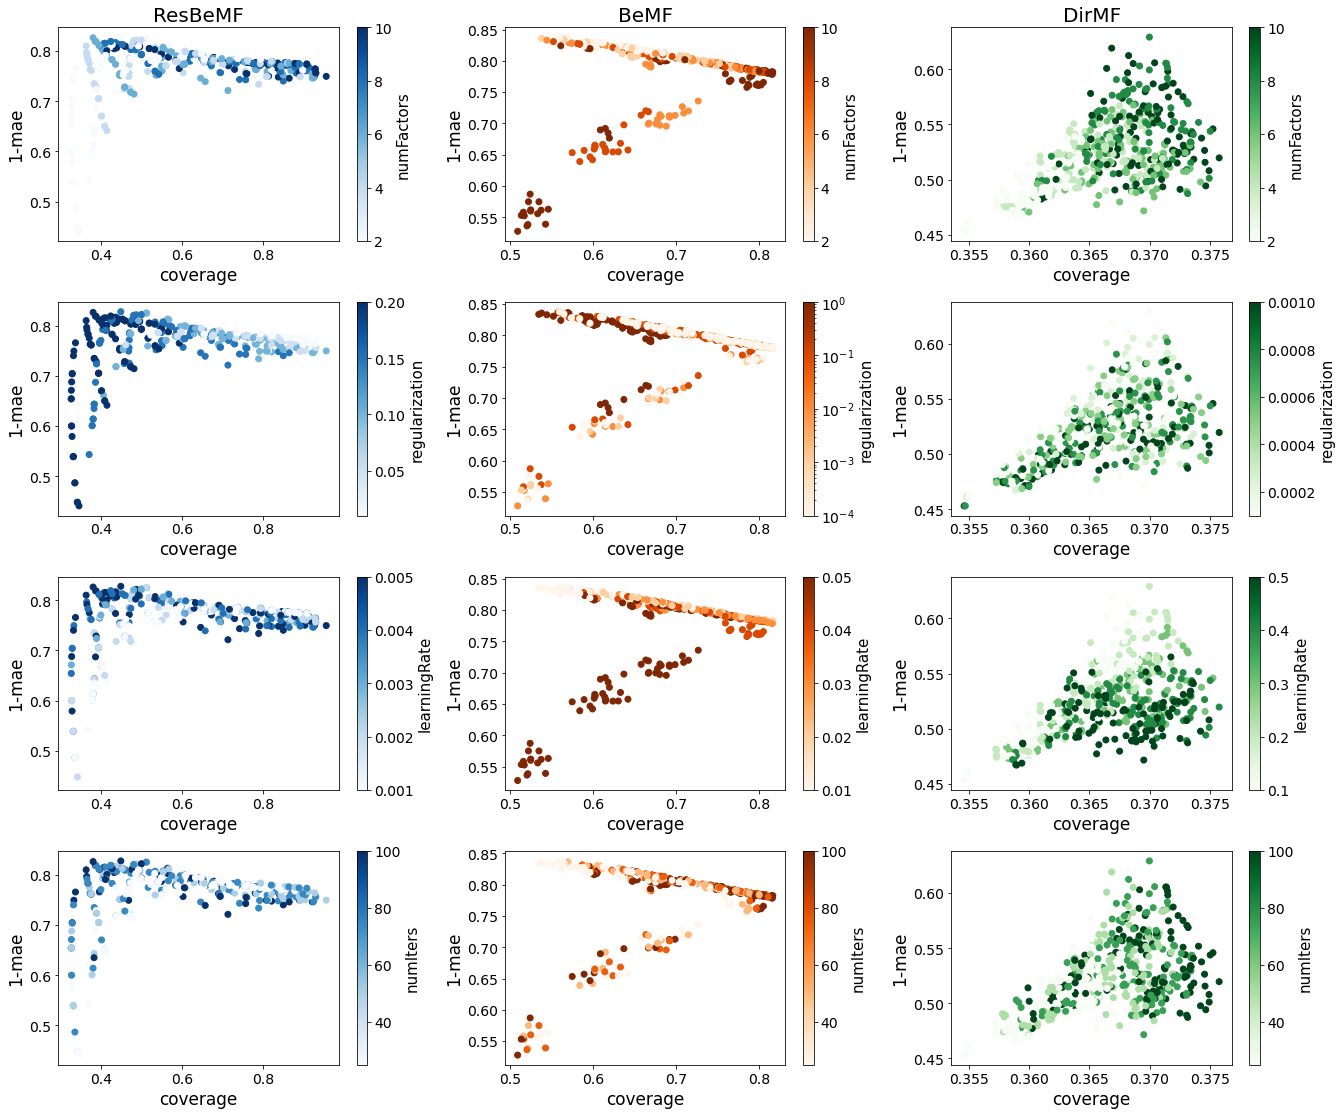

In [7]:
plot_hypeparameters(dfs, 'ft')

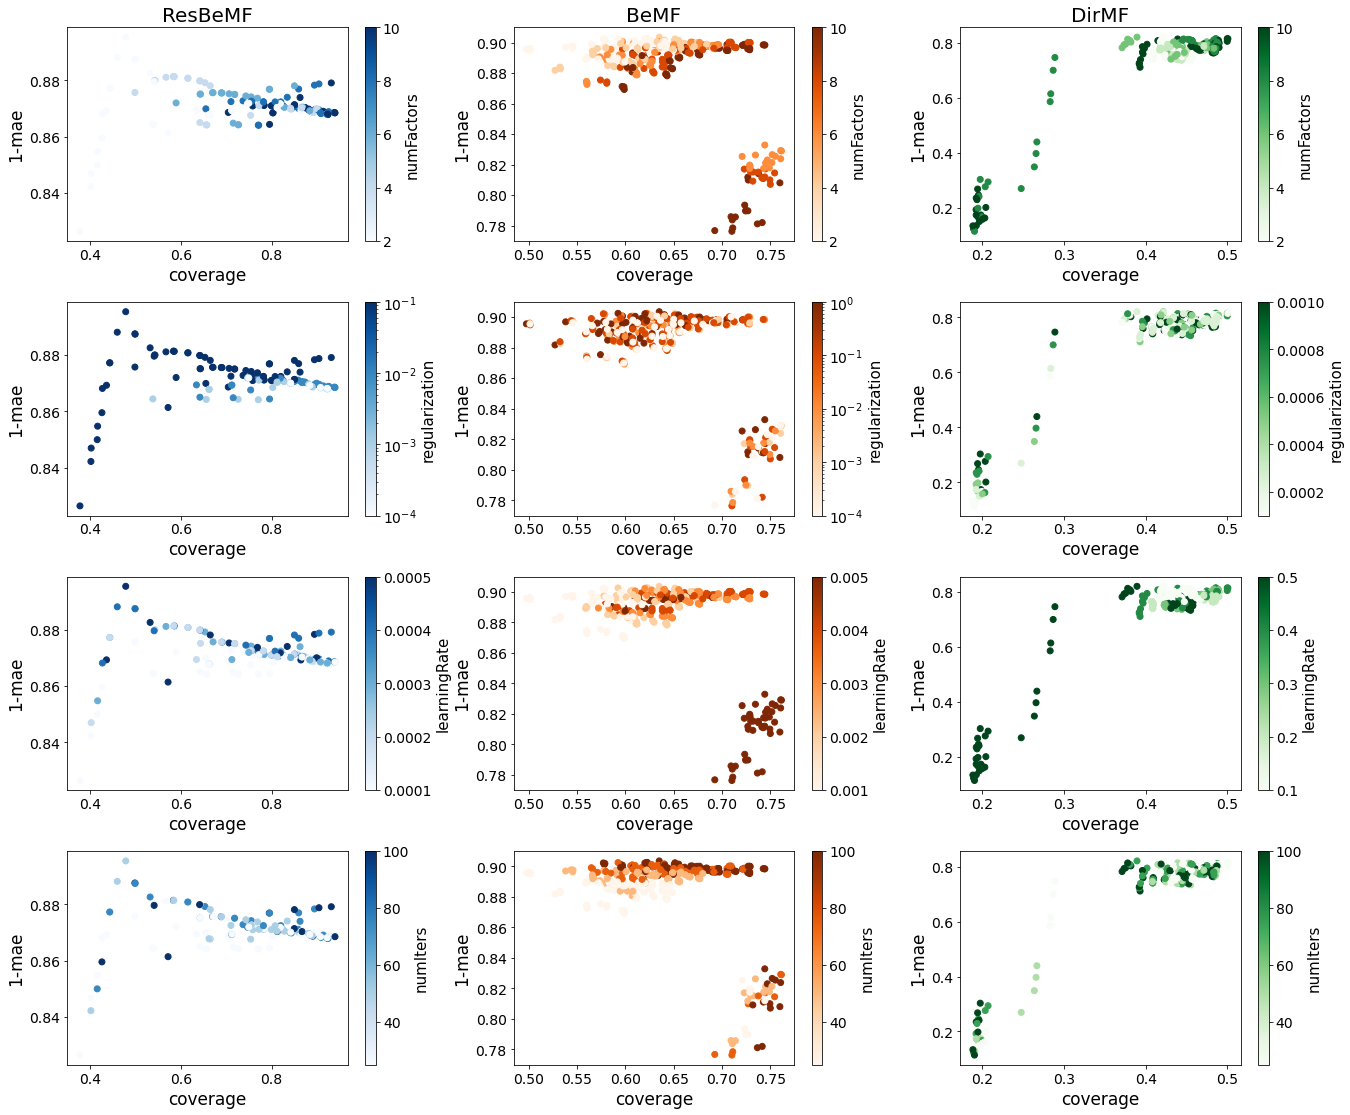

In [8]:
plot_hypeparameters(dfs, 'anime')

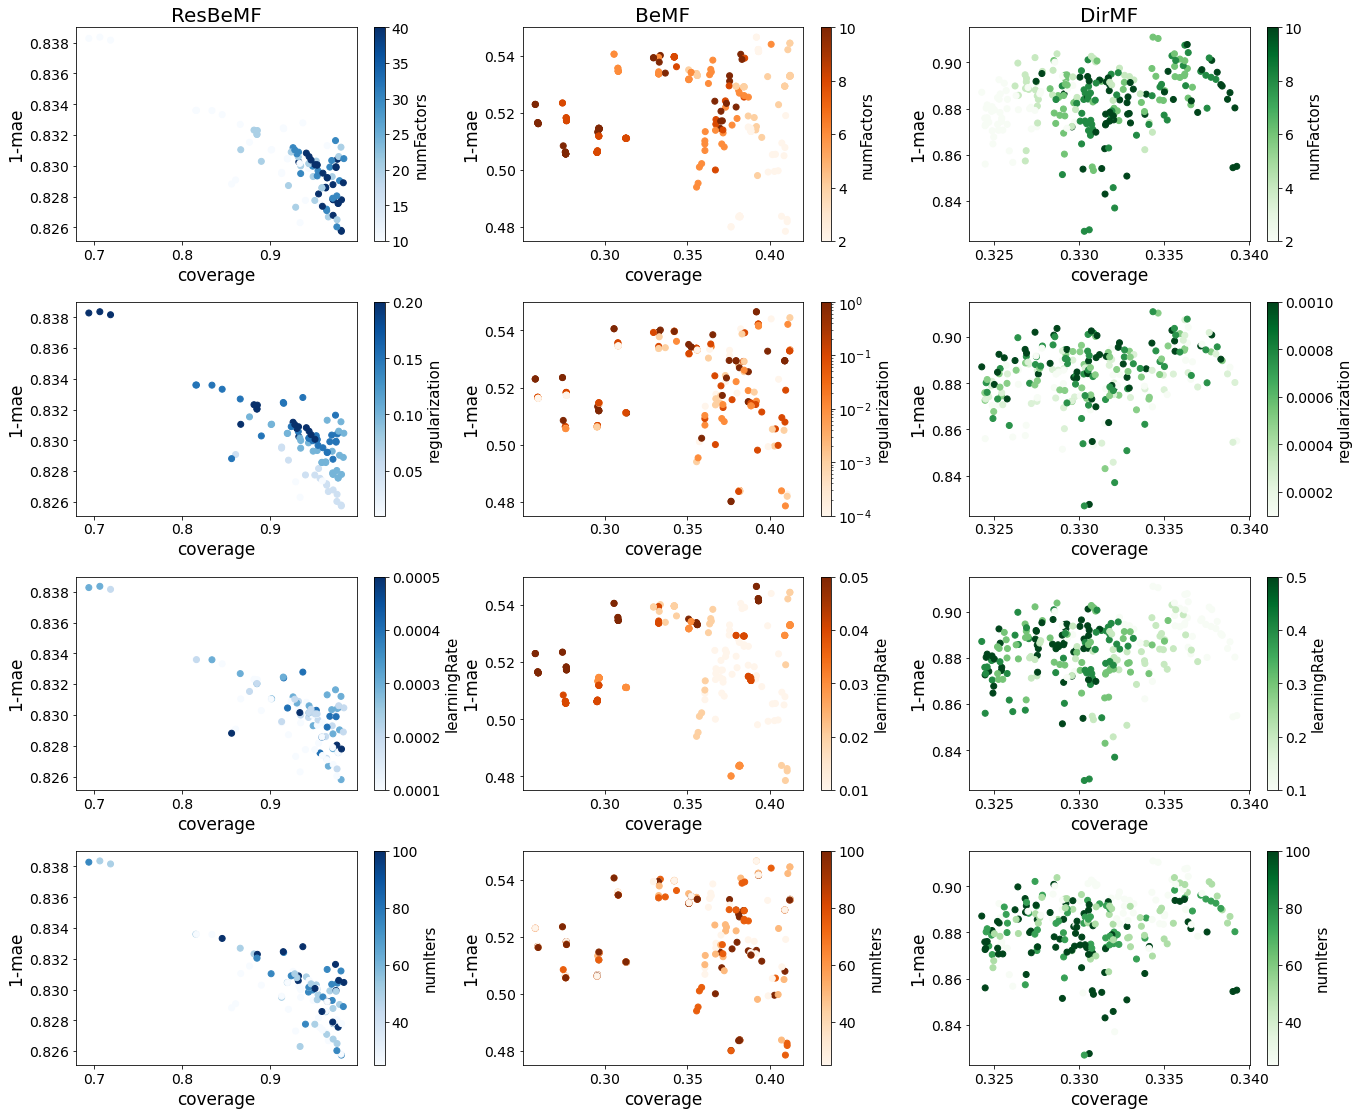

In [9]:
plot_hypeparameters(dfs, 'ml10m')

Plot the pareto fronts:

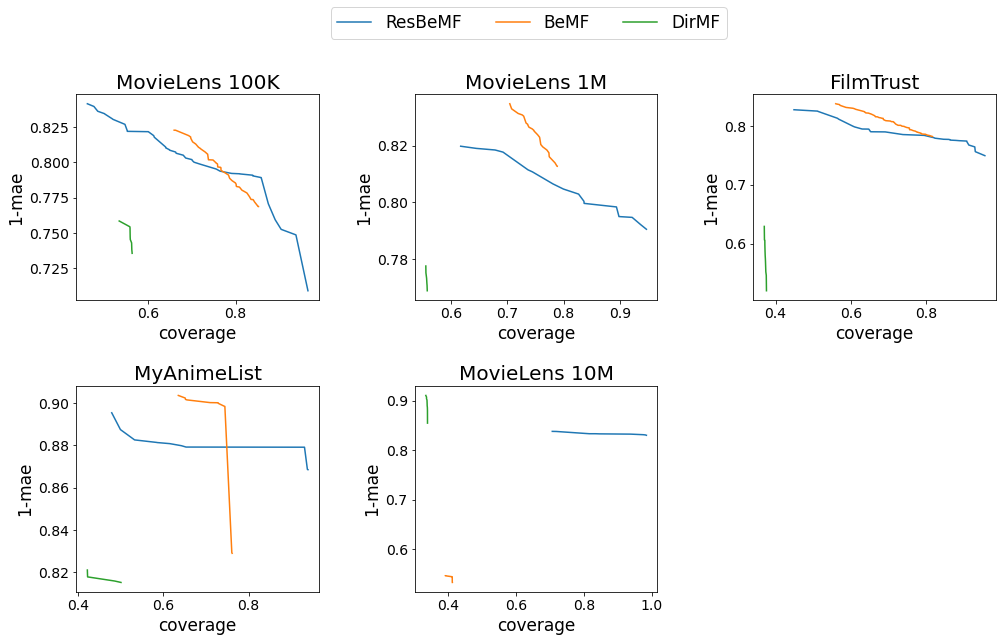

In [10]:
def get_pareto_front(df):
    objectives = [df.columns.get_loc(c) for c in ['cummulativemae_avg', 'cummulativecoverage_avg'] if c in df]
    nondominated = pareto.eps_sort([list(df.itertuples(False))], objectives, maximize_all=True)
    pareto_front = pd.DataFrame.from_records(nondominated, columns=list(df.columns.values))
    s = sorted(zip(pareto_front['cummulativecoverage_avg'], pareto_front['cummulativemae_avg']))
    cov, mae = [list(tuple) for tuple in zip(*s)]
    return cov, mae

def plot_pareto_front(df, title, ax):
    resbemf_coverage, resbemf_mae = get_pareto_front(df['ResBeMF'])
    resbemf_line, = ax.plot(resbemf_coverage, resbemf_mae, label='ResBeMF')

    bemf_coverage, bemf_mae = get_pareto_front(df['BeMF'])
    bemf_line, = ax.plot(bemf_coverage, bemf_mae, label='BeMF')

    dirmf_coverage, dirmf_mae = get_pareto_front(df['DirMF'])
    dirmf_line, = ax.plot(dirmf_coverage, dirmf_mae, label='DirMF')

    ax.set_xlabel('coverage', fontsize=17)
    ax.set_ylabel('1-mae', fontsize=17)
    ax.set_title(title, fontsize=20)
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    return [resbemf_line, bemf_line, dirmf_line]

fig, axs = plt.subplots(2, 3, figsize=(13.5 ,7.5))
fig.tight_layout(h_pad=6.5, w_pad=6.5)
fig.delaxes(axs[1,2])

lines = plot_pareto_front(dfs['ml100k'], 'MovieLens 100K', axs[0,0])
plot_pareto_front(dfs['ml1m'], 'MovieLens 1M', axs[0,1])
plot_pareto_front(dfs['ft'], 'FilmTrust', axs[0,2])
plot_pareto_front(dfs['anime'], 'MyAnimeList', axs[1,0])
plot_pareto_front(dfs['ml10m'], 'MovieLens 10M', axs[1,1])

labels = ["ResBeMF", "BeMF", "DirMF"]
plt.figlegend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.15), fontsize=17)

plt.savefig('./figs/pareto-front.png', dpi=300, bbox_inches='tight')

## Test split error

Define aux functions:

In [3]:
def compute_stats (row):
    row_without_nan = row[~np.isnan(row)]
    mean = np.mean(row_without_nan)
    (lower_ci, upper_ci) = st.t.interval(0.95, len(row_without_nan)-1, loc=mean, scale=st.sem(row_without_nan))
    return [lower_ci, mean, upper_ci]

def get_stats (df, method):
    data = df.loc[:, df.columns.str.startswith(method)].to_numpy()
    return np.array([compute_stats(row) for row in data])    

Plot error in matrix factorization models:

<ipython-input-4-a9cd6954d739>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mae_df[c][i] = math.nan
<ipython-input-4-a9cd6954d739>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_df[c][i] = math.nan
<ipython-input-4-a9cd6954d739>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df[c][i] = math.nan
/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encount

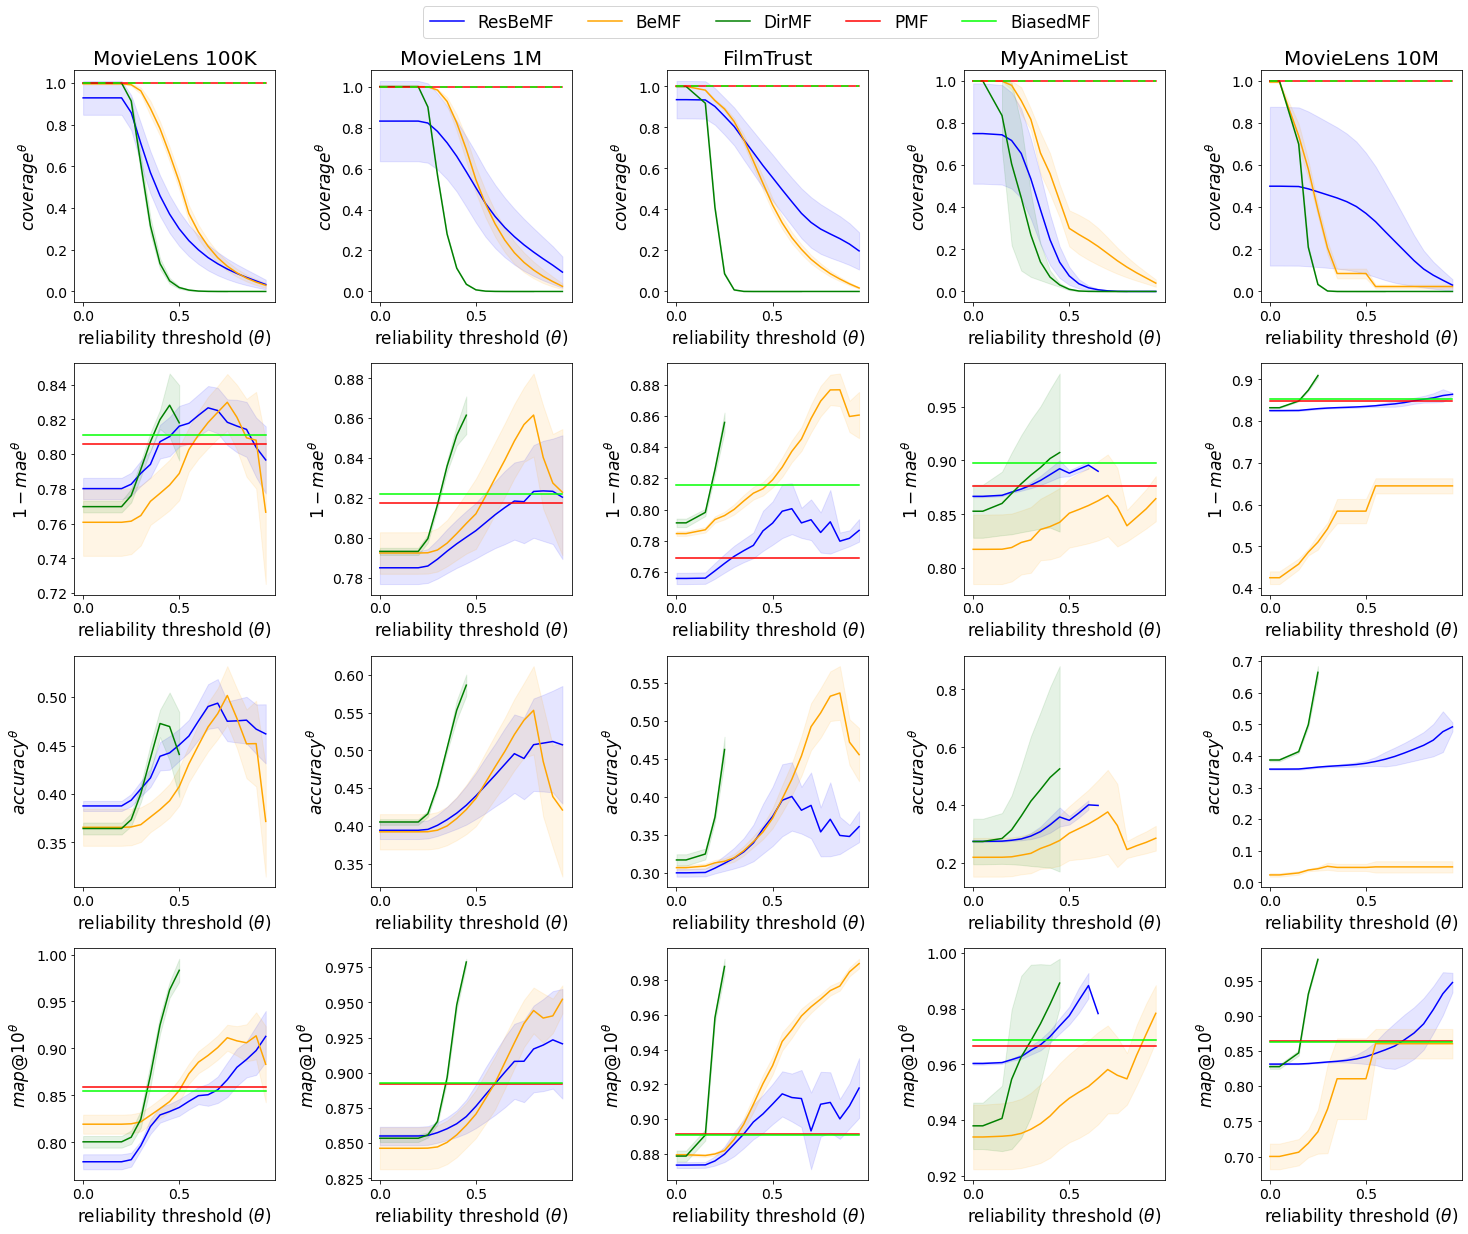

In [4]:
def plot_mf_test_error(dataset, title, axs, column):
    
    # load scores
    
    coverage_df = pd.read_csv('results/test-split/' + dataset + '/coverage.csv')
    mae_df = pd.read_csv('results/test-split/' + dataset + '/mae.csv')
    accuracy_df = pd.read_csv('results/test-split/' + dataset + '/accuracy.csv')
    map_df = pd.read_csv('results/test-split/' + dataset + '/map.csv')

    # filter out scores computed with a coverage lower than 0.02 (2%)
    
    for c in coverage_df.columns.tolist()[1:]:
        for i in range(coverage_df['reliability'].size):
            if coverage_df[c][i] <= 0.02:
                mae_df[c][i] = math.nan
                accuracy_df[c][i] = math.nan
                map_df[c][i] = math.nan

                
    # plot column title
    
    axs[0, column].set_title(title, fontsize=20)
                
    # plot coverage
    
    axs[0, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[0, column].set_ylabel('$coverage^θ$', fontsize=17)

    axs[0, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_coverage_stats = get_stats(coverage_df, 'ResBeMF')
    axs[0, column].fill_between(coverage_df['reliability'], resbemf_coverage_stats[:,0], resbemf_coverage_stats[:,2], color='blue', alpha=0.1)
    resbemf_line, = axs[0, column].plot(coverage_df['reliability'], resbemf_coverage_stats[:,1], c='blue')

    bemf_coverage_stats = get_stats(coverage_df, 'BeMF')
    axs[0, column].fill_between(coverage_df['reliability'], bemf_coverage_stats[:,0], bemf_coverage_stats[:,2], color='orange', alpha=0.1)
    bemf_line, = axs[0, column].plot(coverage_df['reliability'], bemf_coverage_stats[:,1], c='orange')

    dirmf_coverage_stats = get_stats(coverage_df, 'DirMF')
    axs[0, column].fill_between(coverage_df['reliability'], dirmf_coverage_stats[:,0], dirmf_coverage_stats[:,2], color='green', alpha=0.1)
    dirmf_line, = axs[0, column].plot(coverage_df['reliability'], dirmf_coverage_stats[:,1], c='green')

    pmf_line, = axs[0, column].plot(coverage_df['reliability'], coverage_df['PMF'], c='red')
    
    axs[0, column].plot(coverage_df['reliability'], coverage_df['BiasedMF'], c='lime', ls=(0,(5,5)))

    
    # plot mae

    axs[1, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[1, column].set_ylabel('$1-mae^θ$', fontsize=17)

    axs[1, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_mae_stats = get_stats(mae_df, 'ResBeMF')
    axs[1, column].fill_between(mae_df['reliability'], resbemf_mae_stats[:,0], resbemf_mae_stats[:,2], color='blue', alpha=0.1)
    axs[1, column].plot(mae_df['reliability'], resbemf_mae_stats[:,1], c='blue')

    bemf_mae_stats = get_stats(mae_df, 'BeMF')
    axs[1, column].fill_between(mae_df['reliability'], bemf_mae_stats[:,0], bemf_mae_stats[:,2], color='orange', alpha=0.1)
    axs[1, column].plot(mae_df['reliability'], bemf_mae_stats[:,1], c='orange')

    dirmf_mae_stats = get_stats(mae_df, 'DirMF')
    axs[1, column].fill_between(mae_df['reliability'], dirmf_mae_stats[:,0], dirmf_mae_stats[:,2], color='green', alpha=0.1)
    axs[1, column].plot(mae_df['reliability'], dirmf_mae_stats[:,1], c='green')

    axs[1, column].plot(mae_df['reliability'], mae_df['PMF'], c='red')
    
    biasedmf_line, = axs[1, column].plot(mae_df['reliability'], mae_df['BiasedMF'], c='lime')

    # plot accuracy

    axs[2, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[2, column].set_ylabel('$accuracy^θ$', fontsize=17)

    axs[2, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_accuracy_stats = get_stats(accuracy_df, 'ResBeMF')
    axs[2, column].fill_between(accuracy_df['reliability'], resbemf_accuracy_stats[:,0], resbemf_accuracy_stats[:,2], color='blue', alpha=0.1)
    axs[2, column].plot(accuracy_df['reliability'], resbemf_accuracy_stats[:,1], c='blue')

    bemf_accuracy_stats = get_stats(accuracy_df, 'BeMF')
    axs[2, column].fill_between(accuracy_df['reliability'], bemf_accuracy_stats[:,0], bemf_accuracy_stats[:,2], color='orange', alpha=0.1)
    axs[2, column].plot(accuracy_df['reliability'], bemf_accuracy_stats[:,1], c='orange')

    dirmf_accuracy_stats = get_stats(accuracy_df, 'DirMF')
    axs[2, column].fill_between(accuracy_df['reliability'], dirmf_accuracy_stats[:,0], dirmf_accuracy_stats[:,2], color='green', alpha=0.1)
    axs[2, column].plot(accuracy_df['reliability'], dirmf_accuracy_stats[:,1], c='green')

    # plot map

    axs[3, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[3, column].set_ylabel('$map@10^θ$', fontsize=17)

    axs[3, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_map_stats = get_stats(map_df, 'ResBeMF')
    axs[3, column].fill_between(map_df['reliability'], resbemf_map_stats[:,0], resbemf_map_stats[:,2], color='blue', alpha=0.1)
    axs[3, column].plot(map_df['reliability'], resbemf_map_stats[:,1], c='blue')

    bemf_map_stats = get_stats(map_df, 'BeMF')
    axs[3, column].fill_between(map_df['reliability'], bemf_map_stats[:,0], bemf_map_stats[:,2], color='orange', alpha=0.1)
    axs[3, column].plot(map_df['reliability'], bemf_map_stats[:,1], c='orange')

    dirmf_map_stats = get_stats(map_df, 'DirMF')
    axs[3, column].fill_between(map_df['reliability'], dirmf_map_stats[:,0], dirmf_map_stats[:,2], color='green', alpha=0.1)
    axs[3, column].plot(map_df['reliability'], dirmf_map_stats[:,1], c='green')

    axs[3, column].plot(map_df['reliability'], map_df['PMF'], c='red')
    
    axs[3, column].plot(map_df['reliability'], map_df['BiasedMF'], c='lime')

    
    return [resbemf_line, bemf_line, dirmf_line, pmf_line, biasedmf_line]

# create plot

fig, axs = plt.subplots(4, 5, figsize=(20,16))
fig.tight_layout(h_pad=4, w_pad=6.5)

# plot datasets

lines = plot_mf_test_error('ml100k', 'MovieLens 100K', axs, 0)
plot_mf_test_error('ml1m', 'MovieLens 1M', axs, 1)
plot_mf_test_error('ft', 'FilmTrust', axs, 2)
plot_mf_test_error('anime', 'MyAnimeList', axs, 3)
plot_mf_test_error('ml10m', 'MovieLens 10M', axs, 4)

# plot legend

labels = ['ResBeMF', 'BeMF', 'DirMF', 'PMF', 'BiasedMF']
plt.figlegend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize=17)

# export plot

plt.savefig('./figs/mf-test-error.png', dpi=300, bbox_inches='tight')

Plot error in neural network models:

<ipython-input-12-b0a1b8728909>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mae_df[c][i] = math.nan
<ipython-input-12-b0a1b8728909>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_df[c][i] = math.nan
<ipython-input-12-b0a1b8728909>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df[c][i] = math.nan
<ipython-input-12-b0a1b8728909>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

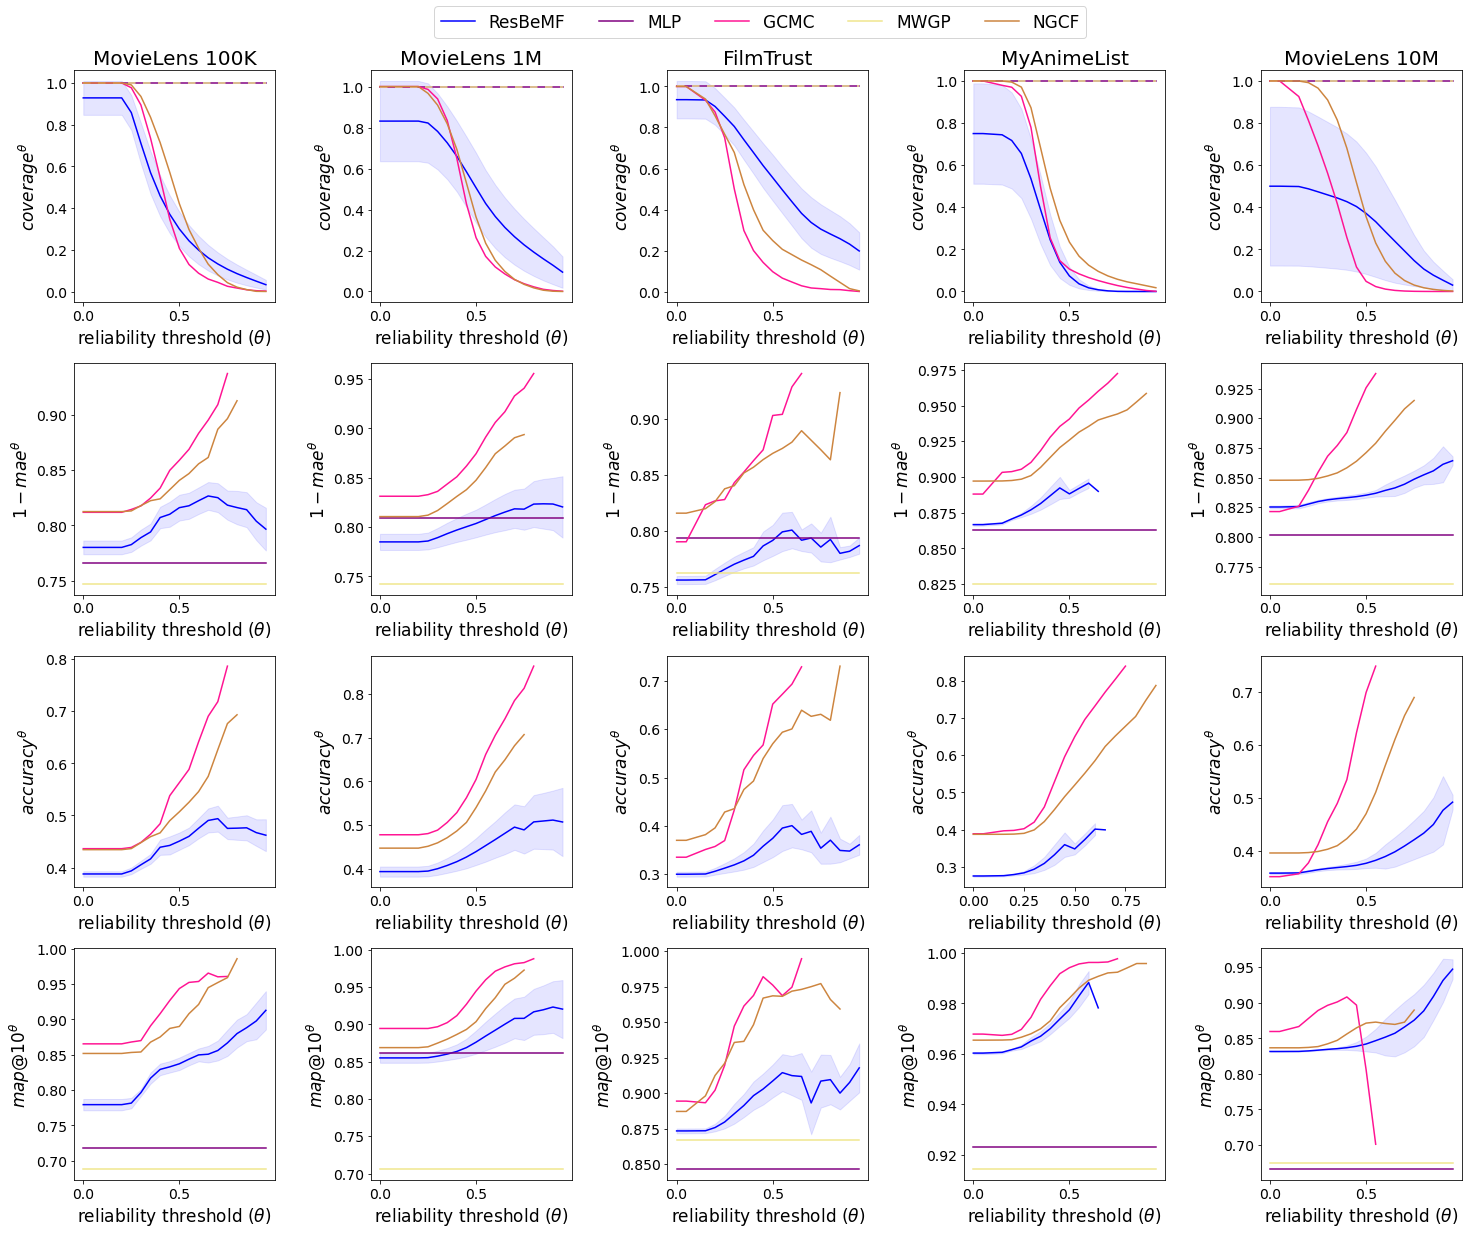

In [12]:
def plot_nn_test_error(dataset, title, axs, column):
    
    # load scores
    
    coverage_df = pd.read_csv('results/test-split/' + dataset + '/coverage.csv')
    mae_df = pd.read_csv('results/test-split/' + dataset + '/mae.csv')
    accuracy_df = pd.read_csv('results/test-split/' + dataset + '/accuracy.csv')
    map_df = pd.read_csv('results/test-split/' + dataset + '/map.csv')

    # filter out scores computed with a coverage lower than 0.02 (2%)
    
    for c in coverage_df.columns.tolist()[1:]:
        for i in range(coverage_df['reliability'].size):
            if coverage_df[c][i] <= 0.02:
                mae_df[c][i] = math.nan
                accuracy_df[c][i] = math.nan
                map_df[c][i] = math.nan

                
    # plot column title
    
    axs[0, column].set_title(title, fontsize=20)
                
    # plot coverage
    
    axs[0, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[0, column].set_ylabel('$coverage^θ$', fontsize=17)

    axs[0, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_coverage_stats = get_stats(coverage_df, 'ResBeMF')
    axs[0, column].fill_between(coverage_df['reliability'], resbemf_coverage_stats[:,0], resbemf_coverage_stats[:,2], color='blue', alpha=0.1)
    resbemf_line, = axs[0, column].plot(coverage_df['reliability'], resbemf_coverage_stats[:,1], c='blue')

    mlp_line, = axs[0, column].plot(coverage_df['reliability'], coverage_df['MLP'], c='purple')

    gcmc_line, = axs[0, column].plot(coverage_df['reliability'], coverage_df['GCMC'], c='deeppink')
    
    axs[0, column].plot(coverage_df['reliability'], coverage_df['MWGP'], c='khaki', ls=(0,(5,5)))
    
    ngcf_line, = axs[0, column].plot(coverage_df['reliability'], coverage_df['NGCF'], c='peru')

    # plot mae

    axs[1, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[1, column].set_ylabel('$1-mae^θ$', fontsize=17)

    axs[1, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_mae_stats = get_stats(mae_df, 'ResBeMF')
    axs[1, column].fill_between(mae_df['reliability'], resbemf_mae_stats[:,0], resbemf_mae_stats[:,2], color='blue', alpha=0.1)
    axs[1, column].plot(mae_df['reliability'], resbemf_mae_stats[:,1], c='blue')

    axs[1, column].plot(mae_df['reliability'], mae_df['MLP'], c='purple')

    axs[1, column].plot(mae_df['reliability'], mae_df['GCMC'], c='deeppink')
    
    mwgp_line, = axs[1, column].plot(mae_df['reliability'], mae_df['MWGP'], c='khaki')
    
    axs[1, column].plot(mae_df['reliability'], mae_df['NGCF'], c='peru')
    

    # plot accuracy

    axs[2, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[2, column].set_ylabel('$accuracy^θ$', fontsize=17)

    axs[2, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_accuracy_stats = get_stats(accuracy_df, 'ResBeMF')
    axs[2, column].fill_between(accuracy_df['reliability'], resbemf_accuracy_stats[:,0], resbemf_accuracy_stats[:,2], color='blue', alpha=0.1)
    axs[2, column].plot(accuracy_df['reliability'], resbemf_accuracy_stats[:,1], c='blue')

    axs[2, column].plot(accuracy_df['reliability'], accuracy_df['GCMC'], c='deeppink')
    
    axs[2, column].plot(accuracy_df['reliability'], accuracy_df['NGCF'], c='peru')
    

    # plot map

    axs[3, column].set_xlabel(r'reliability threshold ($\theta$)', fontsize=17)
    axs[3, column].set_ylabel('$map@10^θ$', fontsize=17)

    axs[3, column].tick_params(axis='both', which='major', labelsize=14)

    resbemf_map_stats = get_stats(map_df, 'ResBeMF')
    axs[3, column].fill_between(map_df['reliability'], resbemf_map_stats[:,0], resbemf_map_stats[:,2], color='blue', alpha=0.1)
    axs[3, column].plot(map_df['reliability'], resbemf_map_stats[:,1], c='blue')

    axs[3, column].plot(map_df['reliability'], map_df['MLP'], c='purple')
    
    axs[3, column].plot(map_df['reliability'], map_df['GCMC'], c='deeppink')

    axs[3, column].plot(map_df['reliability'], map_df['MWGP'], c='khaki')
    
    axs[3, column].plot(map_df['reliability'], map_df['NGCF'], c='peru')

    return [resbemf_line, mlp_line, gcmc_line, mwgp_line, ngcf_line]

# create plot

fig, axs = plt.subplots(4, 5, figsize=(20,16))
fig.tight_layout(h_pad=4, w_pad=6.5)

# plot datasets

lines = plot_nn_test_error('ml100k', 'MovieLens 100K', axs, 0)
plot_nn_test_error('ml1m', 'MovieLens 1M', axs, 1)
plot_nn_test_error('ft', 'FilmTrust', axs, 2)
plot_nn_test_error('anime', 'MyAnimeList', axs, 3)
plot_nn_test_error('ml10m', 'MovieLens 10M', axs, 4)

# plot legend

labels = ['ResBeMF', 'MLP', 'GCMC', 'MWGP', 'NGCF']
plt.figlegend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize=17)

# export plot

plt.savefig('./figs/nn-test-error.png', dpi=300, bbox_inches='tight')